In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
import plotly.offline as py_offline
import plotly.plotly as py
import plotly.graph_objs as go
from sklearn.cluster import KMeans
py_offline.init_notebook_mode(connected=True)
pd.set_option('display.max_columns', None)

In [2]:

df = pd.read_csv('train.csv')
#dropoff_time is not used in test.csv
df = df.drop(['dropoff_datetime'], axis = 1)
df.head()


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [3]:
print(df.shape)

(1458644, 10)


In [4]:
test = pd.read_csv('test.csv')
test.head()


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [5]:
print(test.shape)

(625134, 9)


### reshape the training data

In [6]:
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
df['pick_month'] = df.pickup_datetime.dt.month
df['pick_weekday'] = df.pickup_datetime.dt.weekday+1
df['is_weekend'] = df.pickup_datetime.dt.weekday.map(lambda x: 1 if x>= 5 else 0)
df['pick_minuteofday'] = df.pickup_datetime.dt.hour*60 + df.pickup_datetime.dt.minute

df['week_delta'] = (df.pick_weekday + ((df.pickup_datetime.dt.hour + 
                                              (df.pickup_datetime.dt.minute / 60.0)) / 24.0))

print(df.shape)

(1458644, 15)


In [7]:
# Group passenger_count by type of group
df['no_passengers'] = df.passenger_count.map(lambda x: 1 if x == 0 else 0)
df['one_passenger'] = df.passenger_count.map(lambda x: 1 if x == 1 else 0)
df['few_passengers'] = df.passenger_count.map(lambda x: 1 if x > 1 and x <= 4 else 0)
df['many_passengers'] = df.passenger_count.map(lambda x: 1 if x >= 5 else 0)

#### Group the trip by pick up time using k mean

In [8]:
kmean = KMeans(n_clusters=24, random_state=2).fit(df.pick_minuteofday.values.reshape(-1,1))

In [9]:
df['kmean_pickup_time'] = kmean.predict(df.pick_minuteofday.values.reshape(-1,1))

In [10]:
df.store_and_fwd_flag = df.store_and_fwd_flag.map(dict(Y=1, N=0))

#### plot

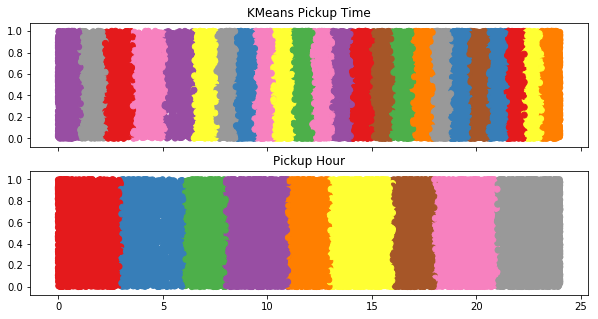

In [11]:
n = 50000 # number of data points to plot
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5))

ax1.scatter(x = df.pick_minuteofday[:n]/60, 
            y = np.random.uniform(0,1, n), 
            cmap = 'Set1',
            c = df.kmean_pickup_time[:n])
ax1.set_title('KMeans Pickup Time')

ax2.scatter(x = df.pick_minuteofday[:n]/60, 
            y = np.random.uniform(0,1, n), 
            cmap = 'Set1',
            c = df.pickup_datetime.dt.hour[:n])
ax2.set_title('Pickup Hour')
plt.show()

### reshape the test data

In [12]:
test.pickup_datetime = pd.to_datetime(test.pickup_datetime)
test['pick_month'] = test.pickup_datetime.dt.month
test['pick_weekday'] = test.pickup_datetime.dt.weekday+1
test['is_weekend'] = test.pickup_datetime.dt.weekday.map(lambda x: 1 if x>= 5 else 0)
test['pick_minuteofday'] = test.pickup_datetime.dt.hour*60 + test.pickup_datetime.dt.minute


test['week_delta'] = (test.pick_weekday + ((test.pickup_datetime.dt.hour + 
                                              (test.pickup_datetime.dt.minute / 60.0)) / 24.0))
print(test.shape)

(625134, 14)


In [13]:
# Group passenger_count by type of group
test['no_passengers'] = test.passenger_count.map(lambda x: 1 if x == 0 else 0)
test['one_passenger'] = test.passenger_count.map(lambda x: 1 if x == 1 else 0)
test['few_passengers'] = test.passenger_count.map(lambda x: 1 if x > 1 and x <= 4 else 0)
test['many_passengers'] = test.passenger_count.map(lambda x: 1 if x >= 5 else 0)

#### Group test data

In [14]:
test['kmean_pickup_time'] = kmean.predict(test.pick_minuteofday.values.reshape(-1,1))

In [15]:
test.store_and_fwd_flag = test.store_and_fwd_flag.map(dict(Y=1, N=0))

## Calculate the holiday 

In [16]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start= df.pickup_datetime.min(),
                        end= df.pickup_datetime.max()).to_pydatetime()
df['is_holiday'] = df.pickup_datetime.isin(holidays)
df['is_holiday'] = df.is_holiday.map(lambda x: 1 if x == True else 0)


In [17]:
test['is_holiday'] = df.pickup_datetime.isin(holidays)
test['is_holiday'] = df.is_holiday.map(lambda x: 1 if x == True else 0)

### testing

In [18]:
kmeans_pickup = KMeans(n_clusters=15, random_state=2).fit(df[['pickup_latitude','pickup_longitude']])
kmeans_dropoff = KMeans(n_clusters=15, random_state=2).fit(df[['dropoff_latitude','dropoff_longitude']])

In [19]:
df['kmeans_pickup'] = kmeans_pickup.predict(df[['pickup_latitude','pickup_longitude']])
df['kmeans_dropoff'] = kmeans_dropoff.predict(df[['dropoff_latitude','dropoff_longitude']])

In [20]:
test['kmeans_pickup'] = kmeans_pickup.predict(test[['pickup_latitude','pickup_longitude']])
test['kmeans_dropoff'] = kmeans_dropoff.predict(test[['dropoff_latitude','dropoff_longitude']])

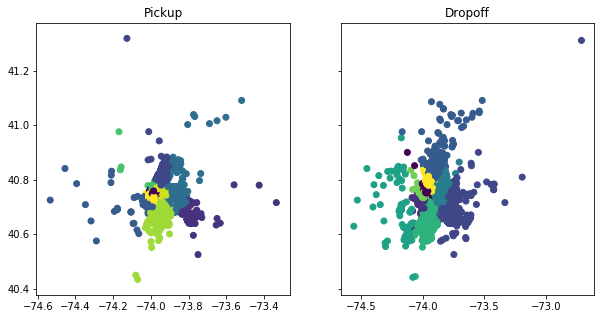

In [21]:
n = 100000 # Number of data points to plot
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax1.scatter(df.pickup_longitude[:n], 
            df.pickup_latitude[:n],
            cmap = 'viridis',
            c = df.kmeans_pickup[:n])
ax1.set_title('Pickup')
ax2.scatter(df.dropoff_longitude[:n], 
            df.dropoff_latitude[:n],
            cmap = 'viridis',
            c = df.kmeans_dropoff[:n])
ax2.set_title('Dropoff')
plt.show()

### calculate the distance between two point

In [22]:
from math import sin, cos, sqrt, atan2, radians
def calculate_distance(table):
    R = 3961

    lat1 = np.radians(table.pickup_latitude.values)
    lon1 = np.radians(table.pickup_longitude.values)
    lat2 = np.radians(table.dropoff_latitude.values)
    lon2 = np.radians(table.dropoff_longitude.values)

    dlon = lon2 - lon1
    dlat = lat2 - lat1 

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return np.round(R * c, 3)

In [23]:
df['distance'] = calculate_distance(df)

In [24]:
test['distance'] = calculate_distance(test)

### add more feature

In [25]:
ride_counts = df.groupby(['pick_month', 'pick_weekday','is_holiday',
           'kmeans_pickup']).size()
ride_counts = pd.DataFrame(ride_counts).reset_index()
ride_counts['ride_counts'] = ride_counts[0]
ride_counts = ride_counts.drop(0,1)

# Add `ride_counts` to dataframe
df = df.merge(ride_counts, on=['pick_month',
                          'pick_weekday',
                          'is_holiday',
                          'kmeans_pickup'], how='left')

In [26]:
ride_counts = test.groupby(['pick_month', 'pick_weekday','is_holiday',
           'kmeans_pickup']).size()
ride_counts = pd.DataFrame(ride_counts).reset_index()
ride_counts['ride_counts'] = ride_counts[0]
ride_counts = ride_counts.drop(0,1)

# Add `ride_counts` to dataframe
test = test.merge(ride_counts, on=['pick_month',
                          'pick_weekday',
                          'is_holiday',
                          'kmeans_pickup'], how='left')

In [27]:
test.shape

(625134, 24)

In [28]:
df.shape

(1458644, 25)

In [29]:
dummies = ['kmean_pickup_time','pick_month','pick_weekday','kmeans_pickup','kmeans_dropoff']
for feature in dummies:
    dummy_features = pd.get_dummies(df[feature], prefix=feature)
    for dummy in dummy_features:
        df[dummy] = dummy_features[dummy]
    df = df.drop([feature], 1)

In [30]:
df.head(1)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,is_weekend,pick_minuteofday,week_delta,no_passengers,one_passenger,few_passengers,many_passengers,is_holiday,distance,ride_counts,kmean_pickup_time_0,kmean_pickup_time_1,kmean_pickup_time_2,kmean_pickup_time_3,kmean_pickup_time_4,kmean_pickup_time_5,kmean_pickup_time_6,kmean_pickup_time_7,kmean_pickup_time_8,kmean_pickup_time_9,kmean_pickup_time_10,kmean_pickup_time_11,kmean_pickup_time_12,kmean_pickup_time_13,kmean_pickup_time_14,kmean_pickup_time_15,kmean_pickup_time_16,kmean_pickup_time_17,kmean_pickup_time_18,kmean_pickup_time_19,kmean_pickup_time_20,kmean_pickup_time_21,kmean_pickup_time_22,kmean_pickup_time_23,pick_month_1,pick_month_2,pick_month_3,pick_month_4,pick_month_5,pick_month_6,pick_weekday_1,pick_weekday_2,pick_weekday_3,pick_weekday_4,pick_weekday_5,pick_weekday_6,pick_weekday_7,kmeans_pickup_0,kmeans_pickup_1,kmeans_pickup_2,kmeans_pickup_3,kmeans_pickup_4,kmeans_pickup_5,kmeans_pickup_6,kmeans_pickup_7,kmeans_pickup_8,kmeans_pickup_9,kmeans_pickup_10,kmeans_pickup_11,kmeans_pickup_12,kmeans_pickup_13,kmeans_pickup_14,kmeans_dropoff_0,kmeans_dropoff_1,kmeans_dropoff_2,kmeans_dropoff_3,kmeans_dropoff_4,kmeans_dropoff_5,kmeans_dropoff_6,kmeans_dropoff_7,kmeans_dropoff_8,kmeans_dropoff_9,kmeans_dropoff_10,kmeans_dropoff_11,kmeans_dropoff_12,kmeans_dropoff_13,kmeans_dropoff_14
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.96463,40.765602,0,455,0,1044,1.725,0,1,0,0,0,0.932,3241,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
dummies = ['kmean_pickup_time','pick_month','pick_weekday','kmeans_pickup','kmeans_dropoff']
for feature in dummies:
    dummy_features = pd.get_dummies(test[feature], prefix=feature)
    for dummy in dummy_features:
        test[dummy] = dummy_features[dummy]
    test = test.drop([feature], 1)

In [32]:
test.head(1)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,is_weekend,pick_minuteofday,week_delta,no_passengers,one_passenger,few_passengers,many_passengers,is_holiday,distance,ride_counts,kmean_pickup_time_0,kmean_pickup_time_1,kmean_pickup_time_2,kmean_pickup_time_3,kmean_pickup_time_4,kmean_pickup_time_5,kmean_pickup_time_6,kmean_pickup_time_7,kmean_pickup_time_8,kmean_pickup_time_9,kmean_pickup_time_10,kmean_pickup_time_11,kmean_pickup_time_12,kmean_pickup_time_13,kmean_pickup_time_14,kmean_pickup_time_15,kmean_pickup_time_16,kmean_pickup_time_17,kmean_pickup_time_18,kmean_pickup_time_19,kmean_pickup_time_20,kmean_pickup_time_21,kmean_pickup_time_22,kmean_pickup_time_23,pick_month_1,pick_month_2,pick_month_3,pick_month_4,pick_month_5,pick_month_6,pick_weekday_1,pick_weekday_2,pick_weekday_3,pick_weekday_4,pick_weekday_5,pick_weekday_6,pick_weekday_7,kmeans_pickup_0,kmeans_pickup_1,kmeans_pickup_2,kmeans_pickup_3,kmeans_pickup_4,kmeans_pickup_5,kmeans_pickup_6,kmeans_pickup_7,kmeans_pickup_8,kmeans_pickup_9,kmeans_pickup_10,kmeans_pickup_12,kmeans_pickup_13,kmeans_pickup_14,kmeans_dropoff_0,kmeans_dropoff_1,kmeans_dropoff_2,kmeans_dropoff_3,kmeans_dropoff_4,kmeans_dropoff_6,kmeans_dropoff_7,kmeans_dropoff_8,kmeans_dropoff_9,kmeans_dropoff_10,kmeans_dropoff_11,kmeans_dropoff_12,kmeans_dropoff_13,kmeans_dropoff_14
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.75668,0,0,1439,4.999306,0,1,0,0,0,1.708,3586,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [33]:
print (df.shape)
print (test.shape)

(1458644, 87)
(625134, 84)


### manunly add missing columns

In [35]:
# test = test.drop(['kmeans_pickup_11'], axis=1)
test.insert(66, 'kmeans_pickup_11', 0)
# test = test.drop(['kmeans_dropoff_5'], axis=1)
test.insert(75, 'kmeans_dropoff_5', 0)

In [36]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,is_weekend,pick_minuteofday,week_delta,no_passengers,one_passenger,few_passengers,many_passengers,is_holiday,distance,ride_counts,kmean_pickup_time_0,kmean_pickup_time_1,kmean_pickup_time_2,kmean_pickup_time_3,kmean_pickup_time_4,kmean_pickup_time_5,kmean_pickup_time_6,kmean_pickup_time_7,kmean_pickup_time_8,kmean_pickup_time_9,kmean_pickup_time_10,kmean_pickup_time_11,kmean_pickup_time_12,kmean_pickup_time_13,kmean_pickup_time_14,kmean_pickup_time_15,kmean_pickup_time_16,kmean_pickup_time_17,kmean_pickup_time_18,kmean_pickup_time_19,kmean_pickup_time_20,kmean_pickup_time_21,kmean_pickup_time_22,kmean_pickup_time_23,pick_month_1,pick_month_2,pick_month_3,pick_month_4,pick_month_5,pick_month_6,pick_weekday_1,pick_weekday_2,pick_weekday_3,pick_weekday_4,pick_weekday_5,pick_weekday_6,pick_weekday_7,kmeans_pickup_0,kmeans_pickup_1,kmeans_pickup_2,kmeans_pickup_3,kmeans_pickup_4,kmeans_pickup_5,kmeans_pickup_6,kmeans_pickup_7,kmeans_pickup_8,kmeans_pickup_9,kmeans_pickup_11,kmeans_pickup_10,kmeans_pickup_12,kmeans_pickup_13,kmeans_pickup_14,kmeans_dropoff_0,kmeans_dropoff_1,kmeans_dropoff_2,kmeans_dropoff_3,kmeans_dropoff_5,kmeans_dropoff_4,kmeans_dropoff_6,kmeans_dropoff_7,kmeans_dropoff_8,kmeans_dropoff_9,kmeans_dropoff_10,kmeans_dropoff_11,kmeans_dropoff_12,kmeans_dropoff_13,kmeans_dropoff_14
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,0,0,1439,4.999306,0,1,0,0,0,1.708,3586,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,0,0,1439,4.999306,0,1,0,0,0,1.715,258,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,0,0,1439,4.999306,0,1,0,0,0,0.812,3586,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,0,0,1439,4.999306,0,1,0,0,0,3.276,3005,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,0,0,1439,4.999306,0,1,0,0,0,0.597,3005,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### new table

In [37]:
#train 
df.head(1)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,is_weekend,pick_minuteofday,week_delta,no_passengers,one_passenger,few_passengers,many_passengers,is_holiday,distance,ride_counts,kmean_pickup_time_0,kmean_pickup_time_1,kmean_pickup_time_2,kmean_pickup_time_3,kmean_pickup_time_4,kmean_pickup_time_5,kmean_pickup_time_6,kmean_pickup_time_7,kmean_pickup_time_8,kmean_pickup_time_9,kmean_pickup_time_10,kmean_pickup_time_11,kmean_pickup_time_12,kmean_pickup_time_13,kmean_pickup_time_14,kmean_pickup_time_15,kmean_pickup_time_16,kmean_pickup_time_17,kmean_pickup_time_18,kmean_pickup_time_19,kmean_pickup_time_20,kmean_pickup_time_21,kmean_pickup_time_22,kmean_pickup_time_23,pick_month_1,pick_month_2,pick_month_3,pick_month_4,pick_month_5,pick_month_6,pick_weekday_1,pick_weekday_2,pick_weekday_3,pick_weekday_4,pick_weekday_5,pick_weekday_6,pick_weekday_7,kmeans_pickup_0,kmeans_pickup_1,kmeans_pickup_2,kmeans_pickup_3,kmeans_pickup_4,kmeans_pickup_5,kmeans_pickup_6,kmeans_pickup_7,kmeans_pickup_8,kmeans_pickup_9,kmeans_pickup_10,kmeans_pickup_11,kmeans_pickup_12,kmeans_pickup_13,kmeans_pickup_14,kmeans_dropoff_0,kmeans_dropoff_1,kmeans_dropoff_2,kmeans_dropoff_3,kmeans_dropoff_4,kmeans_dropoff_5,kmeans_dropoff_6,kmeans_dropoff_7,kmeans_dropoff_8,kmeans_dropoff_9,kmeans_dropoff_10,kmeans_dropoff_11,kmeans_dropoff_12,kmeans_dropoff_13,kmeans_dropoff_14
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.96463,40.765602,0,455,0,1044,1.725,0,1,0,0,0,0.932,3241,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [38]:
#test
test.head(1)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,is_weekend,pick_minuteofday,week_delta,no_passengers,one_passenger,few_passengers,many_passengers,is_holiday,distance,ride_counts,kmean_pickup_time_0,kmean_pickup_time_1,kmean_pickup_time_2,kmean_pickup_time_3,kmean_pickup_time_4,kmean_pickup_time_5,kmean_pickup_time_6,kmean_pickup_time_7,kmean_pickup_time_8,kmean_pickup_time_9,kmean_pickup_time_10,kmean_pickup_time_11,kmean_pickup_time_12,kmean_pickup_time_13,kmean_pickup_time_14,kmean_pickup_time_15,kmean_pickup_time_16,kmean_pickup_time_17,kmean_pickup_time_18,kmean_pickup_time_19,kmean_pickup_time_20,kmean_pickup_time_21,kmean_pickup_time_22,kmean_pickup_time_23,pick_month_1,pick_month_2,pick_month_3,pick_month_4,pick_month_5,pick_month_6,pick_weekday_1,pick_weekday_2,pick_weekday_3,pick_weekday_4,pick_weekday_5,pick_weekday_6,pick_weekday_7,kmeans_pickup_0,kmeans_pickup_1,kmeans_pickup_2,kmeans_pickup_3,kmeans_pickup_4,kmeans_pickup_5,kmeans_pickup_6,kmeans_pickup_7,kmeans_pickup_8,kmeans_pickup_9,kmeans_pickup_11,kmeans_pickup_10,kmeans_pickup_12,kmeans_pickup_13,kmeans_pickup_14,kmeans_dropoff_0,kmeans_dropoff_1,kmeans_dropoff_2,kmeans_dropoff_3,kmeans_dropoff_5,kmeans_dropoff_4,kmeans_dropoff_6,kmeans_dropoff_7,kmeans_dropoff_8,kmeans_dropoff_9,kmeans_dropoff_10,kmeans_dropoff_11,kmeans_dropoff_12,kmeans_dropoff_13,kmeans_dropoff_14
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.75668,0,0,1439,4.999306,0,1,0,0,0,1.708,3586,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


# Prepare the X_train, y_train, and X_test

In [39]:
#save the data into a file so we don't need to reload the data each time
df = df.drop(['pickup_datetime'], axis = 1)
test = test.drop(['pickup_datetime'], axis = 1)

# df.to_csv("prepared.csv", encoding='utf-8', index=False)
# test.to_csv("test_1.csv", encoding='utf-8', index=False)

In [ ]:
df = pd.read_csv('prepared.csv')

test = pd.read_csv('test_1.csv')

In [ ]:
df.head()

In [ ]:
test.head()

In [40]:
# y_train = df['trip_duration']
# X_train = df.drop(['id', 'store_and_fwd_flag', 'trip_duration'], axis=1)
    
y = df['trip_duration']
X = df.drop(['id','passenger_count', 'store_and_fwd_flag', 'trip_duration'], axis=1)

#creat a table first for later submission
result_table = pd.DataFrame(columns =['id', 
                                      'trip_duration', 'trip_duration_2', 'trip_duration_3'])

result_table['id'] = test['id']


X_test = test.drop(['id', 'store_and_fwd_flag'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [41]:
X_train.shape

(977291, 82)

In [42]:
df.isnull().sum()

id                      0
vendor_id               0
passenger_count         0
pickup_longitude        0
pickup_latitude         0
dropoff_longitude       0
dropoff_latitude        0
store_and_fwd_flag      0
trip_duration           0
is_weekend              0
pick_minuteofday        0
week_delta              0
no_passengers           0
one_passenger           0
few_passengers          0
many_passengers         0
is_holiday              0
distance                0
ride_counts             0
kmean_pickup_time_0     0
kmean_pickup_time_1     0
kmean_pickup_time_2     0
kmean_pickup_time_3     0
kmean_pickup_time_4     0
kmean_pickup_time_5     0
kmean_pickup_time_6     0
kmean_pickup_time_7     0
kmean_pickup_time_8     0
kmean_pickup_time_9     0
kmean_pickup_time_10    0
                       ..
kmeans_pickup_0         0
kmeans_pickup_1         0
kmeans_pickup_2         0
kmeans_pickup_3         0
kmeans_pickup_4         0
kmeans_pickup_5         0
kmeans_pickup_6         0
kmeans_picku

In [43]:
result_table.head()

,id,trip_duration,trip_duration_2,trip_duration_3
0,id3004672,NaN,NaN,NaN
1,id3505355,NaN,NaN,NaN
2,id1217141,NaN,NaN,NaN
3,id2150126,NaN,NaN,NaN
4,id1598245,NaN,NaN,NaN


# begin prediction

In [44]:
from sklearn.metrics import mean_squared_error
def calculate_error(y_test, y_pred):

    log_test = np.log(y_test+1)
    log_pred = np.log(y_pred+1)
    RMSE = np.sqrt(mean_squared_error(log_test, log_pred))
    
    return RMSE

# Random forest

In [45]:
from sklearn.ensemble import RandomForestRegressor as RFR
regr = RFR(n_estimators = 1,
          max_depth = 30,
          min_samples_split = 60,
          verbose = 2,
          random_state = 2)

regr.fit(X_train, y_train)

building tree 1 of 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.3s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=60,
           min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=1,
           oob_score=False, random_state=2, verbose=2, warm_start=False)

In [46]:
y_pred = regr.predict(X_test)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


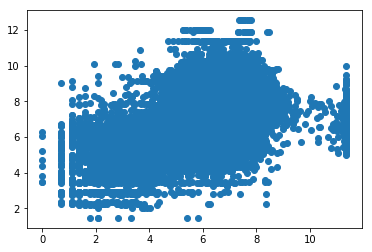

In [47]:
plt.scatter(np.log(y_test), np.log(y_pred))

plt.show()

In [48]:
rmlse = calculate_error(y_pred, y_test)
print("the error for modle with date is: {}".format(rmlse))

the error for modle with date is: 0.5697242260366239


In [49]:
regr.feature_importances_

array([  1.81241462e-03,   5.71820661e-02,   2.59016151e-01,
         5.39393509e-02,   9.64977264e-02,   2.49389865e-05,
         4.50199646e-02,   1.44388784e-01,   1.88584569e-06,
         1.60768021e-05,   3.35126216e-04,   1.17393956e-03,
         0.00000000e+00,   1.04319693e-01,   1.34271099e-02,
         9.91745922e-04,   6.60211993e-05,   2.54408242e-04,
         2.66885455e-04,   1.47410820e-03,   1.18490984e-03,
         4.74093103e-04,   8.98311031e-04,   1.98111700e-07,
         1.96735625e-01,   5.49318888e-04,   1.22773272e-07,
         1.45172542e-04,   2.88721806e-04,   2.23179911e-03,
         1.31296432e-04,   9.43097402e-04,   9.16055297e-04,
         1.19024814e-03,   5.63387195e-04,   1.21728237e-03,
         2.53329235e-04,   5.30338151e-04,   6.48556860e-05,
         1.39337661e-03,   7.17349712e-04,   6.04129938e-04,
         1.20793760e-04,   4.00686088e-04,   1.28736031e-03,
         6.63536276e-06,   3.95718969e-04,   4.68719096e-04,
         1.94511759e-03,

In [50]:
import operator

dict_feature_imp = dict(zip(list(X_train.columns), regr.feature_importances_))
sorted_feature = sorted(dict_feature_imp.items(), key = operator.itemgetter(1), reverse= True)
sorted_feature

[('pickup_latitude', 0.25901615070788703),
 ('kmean_pickup_time_9', 0.19673562497810057),
 ('week_delta', 0.14438878419022552),
 ('distance', 0.1043196925685686),
 ('dropoff_latitude', 0.096497726431149441),
 ('pickup_longitude', 0.057182066086743095),
 ('dropoff_longitude', 0.053939350888014201),
 ('pick_minuteofday', 0.045019964615860893),
 ('ride_counts', 0.013427109870044985),
 ('kmean_pickup_time_14', 0.002231799111927188),
 ('pick_weekday_4', 0.0019451175938732003),
 ('kmeans_pickup_10', 0.0018644739529765364),
 ('vendor_id', 0.0018124146215630964),
 ('kmean_pickup_time_4', 0.0014741081994830117),
 ('pick_month_1', 0.0013933766144111344),
 ('pick_month_6', 0.0012873603107500056),
 ('kmean_pickup_time_20', 0.0012172823739884677),
 ('kmean_pickup_time_18', 0.0011902481444986215),
 ('kmean_pickup_time_5', 0.0011849098376076369),
 ('many_passengers', 0.0011739395640430542),
 ('kmean_pickup_time_0', 0.00099174592202467171),
 ('kmean_pickup_time_16', 0.00094309740205745639),
 ('kmean_p

In [51]:
rmlse = calculate_error(y_pred, y_test)
print("the error for modle with date is: {}".format(rmlse))

the error for modle with date is: 0.5697242260366239


In [52]:
y_test.values

array([1040,  827,  614, ...,  454, 1947, 1217])

In [53]:
y_pred

array([  803.47014925,   761.87234043,   349.31944444, ...,   500.11904762,
        1835.80952381,   918.46153846])

# MLP Regressor

## thought about MLP

base on the model I ran, the error for modle with "relu" is the lowest. Hence, I decided to run a Gridsearch function for tunning

In [64]:
from sklearn.neural_network import MLPRegressor
param_hidden_layers = [(1, 2),(7,2), (8,2), (10, 4),(13,6)]

RMSE_train_test = {}
regMLPs = {}
for param_hidden in param_hidden_layers:
    regMLP_t = MLPRegressor(
                hidden_layer_sizes= param_hidden, activation='relu', solver='adam', alpha=0.001, batch_size='auto',
                learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True,
                random_state=9, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
                early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    regMLP_t.fit(X_train, y_train)
    y_pred = regMLP_t.predict(X_test)
    rmlse = calculate_error(y_pred, y_test)
    print("the error for {} hidden_laye is: {}".format(param_hidden, rmlse))

the error for (1, 2) hidden_laye is: 0.7605391236409907
the error for (7, 2) hidden_laye is: 0.8895771069193265
the error for (8, 2) hidden_laye is: 0.6795053052006176
the error for (10, 4) hidden_laye is: 0.6499066303562581


/home/zhangtong/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

invalid value encountered in log



ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [53]:
param_hidden_layers = [(11,2), (13,2), (10, 2)]

RMSE_train_test = {}
regMLPs = {}
for param_hidden in param_hidden_layers:
    regMLP_t = MLPRegressor(
                hidden_layer_sizes= param_hidden, activation='relu', solver='adam', alpha=0.001, batch_size='auto',
                learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True,
                random_state=9, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
                early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    regMLP_t.fit(X_train, y_train)
    y_pred = regMLP_t.predict(X_test)
    rmlse = calculate_error(y_pred, y_test)
    print("the error for {} hidden_laye is: {}".format(param_hidden, rmlse))

the error for (11, 2) hidden_laye is: 0.6536540903721386
the error for (13, 2) hidden_laye is: 0.5692874642254784
the error for (10, 2) hidden_laye is: 0.5714602847705866


base on the result above, I choose to test different learning rate on (10, 2), (13, 2) using K-fold

In [56]:
from sklearn.neural_network import MLPRegressor

param_hidden_layers = (10,2)


lrate = [0.005, 0.01, 0.001]

for lrate_ in lrate:
    regMLP = MLPRegressor(
                hidden_layer_sizes= param_hidden_layers, activation='relu', solver='adam', alpha=0.001, batch_size='auto',
                learning_rate='adaptive', learning_rate_init=lrate_, power_t=0.5, max_iter=1000, shuffle=True,
                random_state=9, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
                early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    regMLP.fit(X_train, y_train)
    y_pred = regMLP.predict(X_test)
    rmlse = calculate_error(y_pred, y_test)
    print("the error for learning rate {} hidden_laye is: {}".format(lrate_, rmlse))
    


the error for learning rate 0.005 hidden_laye is: 0.5903070465351765


/home/zhangtong/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

invalid value encountered in log



ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [55]:
param_hidden_layers = (10,3)
from sklearn.neural_network import MLPRegressor
lrate = [0.005, 0.001, 0.01]

for lrate_ in lrate:
    regMLP = MLPRegressor(
                hidden_layer_sizes= param_hidden_layers, activation='relu', solver='adam', alpha=0.001, batch_size='auto',
                learning_rate='adaptive', learning_rate_init=lrate_, power_t=0.5, max_iter=1000, shuffle=True,
                random_state=9, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
                early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    regMLP.fit(X_train, y_train)
    y_pred = regMLP.predict(X_test)
    rmlse = calculate_error(y_pred, y_test)
    print("the error for learning rate {} hidden_laye is: {}".format(lrate_, rmlse))

the error for learning rate 0.005 hidden_laye is: 0.6097401580690353
the error for learning rate 0.001 hidden_laye is: 0.7684940612067733
the error for learning rate 0.01 hidden_laye is: 0.5938659755838116
